In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
train_path = '/content/drive/MyDrive/workspace/tf_work/dataset/training_data'
valid_path = '/content/drive/MyDrive/workspace/tf_work/dataset/validation_data'

In [4]:
train_generator = image_dataset_from_directory(train_path,
                                    shuffle=True,
                                    image_size=(224, 224),
                                    batch_size=32)

Found 1610 files belonging to 2 classes.


In [5]:
valid_generator = image_dataset_from_directory(valid_path,
                                    shuffle=True,
                                    image_size=(224, 224),
                                    batch_size=32)

Found 400 files belonging to 2 classes.


In [6]:
class_names = train_generator.class_names
print(class_names)

['notsmoking', 'smoking']


In [7]:
# buffering prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
valid_generator = valid_generator.prefetch(buffer_size=AUTOTUNE)

In [8]:
# data augmentation
data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])

In [9]:
# BUILD MODEL
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

4349952/4334752 [==============================] - 0s 0us/step
(32, 7, 7, 576)


In [10]:
# convolution base model freeze
base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_aug(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = Flatten(name="flatten")(x)
# x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
# outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [11]:
# COMPILE AND FitMODEL
Batch_Size = 32
epochs = 50

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()
print(len(model.trainable_variables))

loss0, accuracy0 = model.evaluate(valid_generator)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1)                 577   

In [12]:
# model fit :: training
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=epochs)

Epoch 1/50
51/51 [==============================] - 128s 2s/step - loss: 0.8575 - accuracy: 0.5000 - val_loss: 0.7473 - val_accuracy: 0.5150
Epoch 2/50
51/51 [==============================] - 45s 804ms/step - loss: 0.8440 - accuracy: 0.4988 - val_loss: 0.7270 - val_accuracy: 0.5200
Epoch 3/50
51/51 [==============================] - 45s 805ms/step - loss: 0.8040 - accuracy: 0.5273 - val_loss: 0.7050 - val_accuracy: 0.5550
Epoch 4/50
51/51 [==============================] - 45s 798ms/step - loss: 0.7895 - accuracy: 0.5559 - val_loss: 0.6894 - val_accuracy: 0.5550
Epoch 5/50
51/51 [==============================] - 44s 792ms/step - loss: 0.7354 - accuracy: 0.5776 - val_loss: 0.6701 - val_accuracy: 0.5750
Epoch 6/50
51/51 [==============================] - 44s 795ms/step - loss: 0.7382 - accuracy: 0.5839 - val_loss: 0.6510 - val_accuracy: 0.6000
Epoch 7/50
51/51 [==============================] - 45s 800ms/step - loss: 0.7145 - accuracy: 0.6137 - val_loss: 0.6421 - val_accuracy: 0.6025
E

In [13]:
loss, accuracy = model.evaluate(train_generator)
print('train eval loss, acc: ', loss, accuracy)

51/51 [==============================] - 33s 557ms/step - loss: 0.3991 - accuracy: 0.7938
train eval loss, acc:  0.3990825116634369 0.7937887907028198


In [14]:
# fine tuning
base_model.trainable = True

print("Number of layers in the base model : ", len(base_model.layers))
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),
              metrics=['accuracy'])
model.summary()
print(len(model.trainable_variables))

fine_tune_epochs = 50
total_epochs =  50 + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Number of layers in the base model :  229
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)     

In [15]:
model.save('./model/save_model')
model.save('./model/model', save_format='h5')

INFO:tensorflow:Assets written to: ./model/save_model/assets


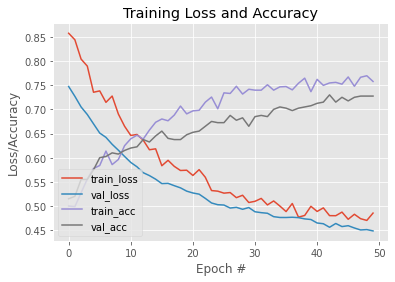

In [16]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("ploy.jpg")

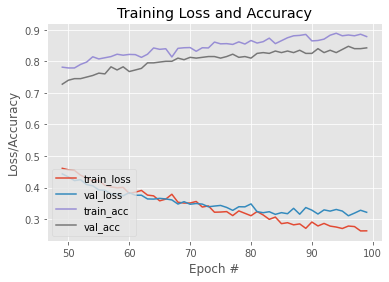

In [17]:
N = total_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(epochs - 1, N), history_fine.history["loss"], label="train_loss")
plt.plot(np.arange(epochs - 1, N), history_fine.history["val_loss"], label="val_loss")
plt.plot(np.arange(epochs - 1, N), history_fine.history["accuracy"], label="train_acc")
plt.plot(np.arange(epochs - 1, N), history_fine.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("ploy_fine.jpg")

In [18]:
test_path = '/content/drive/MyDrive/workspace/tf_work/dataset/testing_data'
testing_dataset = image_dataset_from_directory(test_path,
                                               shuffle=True,
                                               batch_size=32,
                                               image_size=(224, 224))

Found 400 files belonging to 2 classes.


In [19]:
loss, accuracy = model.evaluate(testing_dataset)
print('Test accuracy : ', accuracy)

13/13 [==============================] - 37s 859ms/step - loss: 0.3561 - accuracy: 0.8325
Test accuracy :  0.8324999809265137


In [20]:
# Retrieve a batch of images from the test set
image_batch, label_batch = testing_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [21]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0]
Labels:
 [1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0]


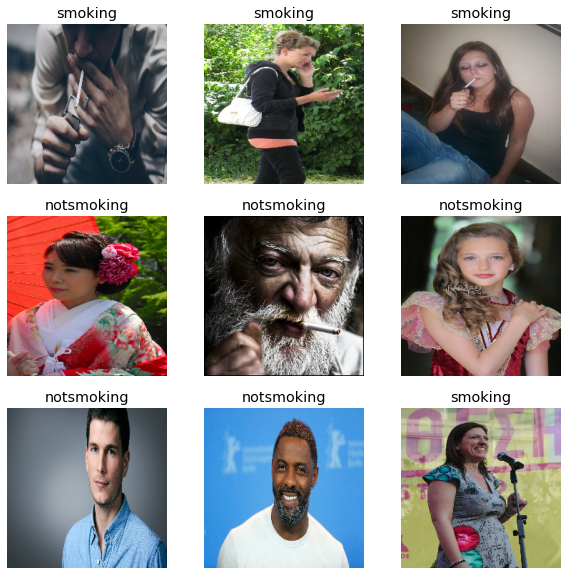

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
plt.savefig("predict.jpg")